In [1]:
!python --version

Python 3.7.16


In [1]:
import helpers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
envs = helpers.create_envs(yamls_filename='2_region_yamls')
agents_no_negotiation = helpers.create_agents(envs[0])
agents_negotiation = helpers.create_agents(envs[0])
mean_reward = helpers.get_mean_reward(envs[0])

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.70it/s]


In [3]:
def plot_rewards(rewards, w = 1000, pos = False):
    
    rewards = np.array(rewards)
    if pos:
        rewards = rewards[rewards > 0]
    plt.scatter(range(len(rewards)), rewards, alpha = .3, s = .2)
    plt.plot(np.convolve(rewards, np.ones(w) / w, mode = 'valid'), color = 'orange', linewidth = 2)
    plt.show()

In [4]:
all_action_rewards = helpers.train(agents_no_negotiation, envs, epochs = 30, communication_on=False)

100%|███████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]


In [5]:
d = helpers.train(agents_negotiation, envs, mean_rewards = mean_reward)

100%|█████████████████████████████████████████| 100/100 [08:57<00:00,  5.38s/it]


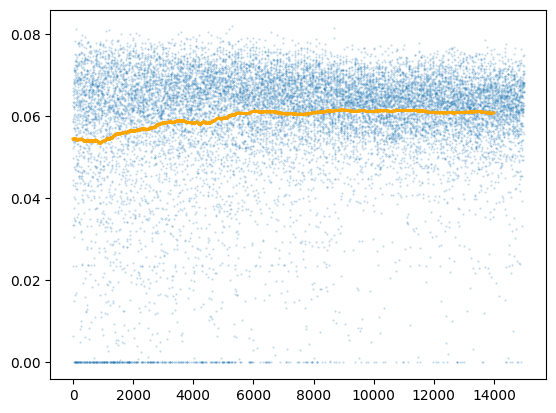

In [6]:
plot_rewards(all_action_rewards[1], w = 1000)

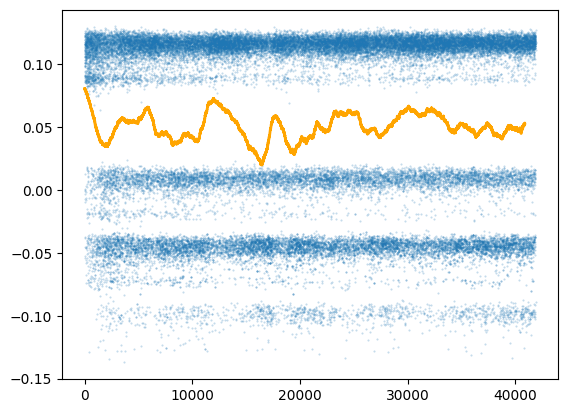

In [7]:
plot_rewards(d['proposal'][0])

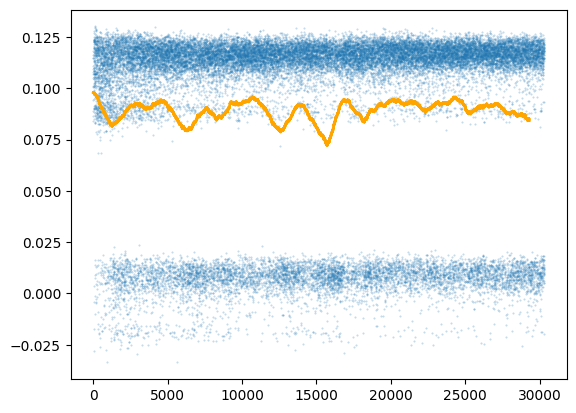

In [8]:
plot_rewards(d['decision'][0])

In [9]:
a = helpers.eval_agents(agents_no_negotiation, envs[0], communication_on = False)
a = np.stack(list(map(lambda x: x['global_temperature']['value'], a)))
a.mean(0)

array([[0.85      , 0.0068    ],
       [0.9886611 , 0.02788   ],
       [1.1075203 , 0.05189953],
       [1.2111455 , 0.07829005],
       [1.3027904 , 0.10661143],
       [1.3848486 , 0.1365159 ],
       [1.4592956 , 0.16772422],
       [1.5274874 , 0.20001352],
       [1.5903814 , 0.23320036],
       [1.648886  , 0.2671299 ],
       [1.7040564 , 0.30167374],
       [1.756142  , 0.33673334],
       [1.8058885 , 0.37221855],
       [1.8534359 , 0.4080603 ],
       [1.899092  , 0.4441947 ],
       [1.9430959 , 0.48056716],
       [1.9855893 , 0.5171304 ],
       [2.0270112 , 0.5538418 ],
       [2.0673566 , 0.59067106],
       [2.1069198 , 0.62758815],
       [2.1455145 , 0.66457146]], dtype=float32)

In [10]:
rand_runs = helpers.random_runs(envs[0])
rand_runs = np.stack(list(map(lambda x: x['global_temperature']['value'], rand_runs)))
rand_runs.mean(0)

array([[0.85      , 0.0068    ],
       [0.9886611 , 0.02788   ],
       [1.1077403 , 0.05189953],
       [1.2111465 , 0.07829554],
       [1.3026674 , 0.10661681],
       [1.3848268 , 0.13651809],
       [1.4592458 , 0.16772579],
       [1.5278262 , 0.20001379],
       [1.5908186 , 0.2332091 ],
       [1.6499064 , 0.26714936],
       [1.7056315 , 0.30171826],
       [1.7585735 , 0.3368161 ],
       [1.8093779 , 0.37236002],
       [1.8580549 , 0.40828556],
       [1.9052522 , 0.4445297 ],
       [1.9509385 , 0.4810478 ],
       [1.9956982 , 0.5177951 ],
       [2.0392492 , 0.5547427 ],
       [2.0827656 , 0.5918552 ],
       [2.1246507 , 0.62912804],
       [2.1649177 , 0.6665162 ]], dtype=float32)

In [16]:
nego_runs = helpers.eval_agents(agents_negotiation, envs[0])
nego_runs_t = np.stack(list(map(lambda x: x['global_temperature']['value'], nego_runs['global_states'])))
nego_runs_t.mean(0)

array([[0.85      , 0.0068    ],
       [0.9886611 , 0.02788   ],
       [1.1073953 , 0.05189953],
       [1.2109398 , 0.07828693],
       [1.3027285 , 0.10660324],
       [1.3850596 , 0.13650636],
       [1.4598334 , 0.16772021],
       [1.5284922 , 0.20002303],
       [1.5922084 , 0.23323476],
       [1.651836  , 0.26720908],
       [1.7077672 , 0.30182475],
       [1.7608442 , 0.33697334],
       [1.811335  , 0.3725701 ],
       [1.8595078 , 0.40853924],
       [1.9057316 , 0.44481343],
       [1.9505081 , 0.4813364 ],
       [1.9938313 , 0.51806575],
       [2.0359323 , 0.55495983],
       [2.077041  , 0.59198415],
       [2.117291  , 0.6291106 ],
       [2.1565814 , 0.6663151 ]], dtype=float32)

In [18]:
nego_runs_r = np.stack(list(map(lambda x: x['rewards_proposals'], nego_runs['nego_states'])))
nego_runs_r

array([[[[ 0., -2.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 1., -2.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [-1.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        ...,

        [[ 0., -2.],
         [ 0.,  1.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0., -2.],
         [ 0.,  0.],
         [ 0., -2.],
         [-1.,  0.]],

        [[ 0.,  1.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 1.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0., -1.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        ...,

       

In [55]:
env = envs[0]
state = env.reset()
for t in range(env.episode_length):
    
    for agent in agents_negotiation:
        agent.reset_negotiation_hs()

    for step in range(env.max_negotiation_steps):

        proposals = [agent.eval_make_proposals(state[agent.id]) for agent in agents_negotiation]
        #proposals = [{'promises' : p['promises'][0], 'proposals' : p['proposals'][0]} for p in proposals]
        state = env.register_proposals(proposals)

        decisions = [agent.eval_make_decisions(state[agent.id]) for agent in agents_negotiation]
        #decisions = [d[0] for d in decisions]
        state = env.register_decisions(decisions)
    
    actions = {agent.id: agent.eval_act(state[agent.id]) for agent in agents_negotiation}
    #print(actions[0])
    
    state, _, _, _ = env.step(actions)